## ULMFIT

In [3]:
import os, sys

print('Importing dataset...')

from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/Stance Detection")

Importing dataset...
Mounted at /content/drive


In [4]:
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [5]:
path = Path('./dataset')
trainfile = 'train.csv'
testfile = 'test.csv'

In [6]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [ ]:
train_orig = pd.read_csv(path/trainfile, encoding = "latin-1")
train_orig.head()

,Party,Tweet,Republican,Democrat,None
0,Democrat,The Student Non-Discrimination Act will put an...,0,1,0
1,Republican,Ready for totality! Taking in #SolarEclipse201...,1,0,0
2,Democrat,Despite Republicans allowing them to go w/o fu...,0,1,0
3,Republican,We have an opportunity to finally gain operati...,1,0,0
4,Democrat,Honored to be included in @NYGovCuomo's #Women...,0,1,0


In [ ]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.8.1+cu101


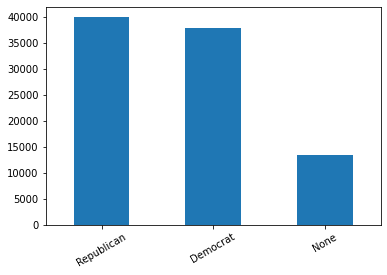

In [ ]:
train_orig['Party'].value_counts().plot.bar(rot=30)

In [ ]:
train_orig['Party'].isnull().values.any()

False

In [ ]:
train_orig['Tweet'].isnull().values.any()

True

In [ ]:
train_orig.Tweet = train_orig.Tweet.fillna('')

In [ ]:
train_orig['Tweet'].isnull().values.any()

False

In [ ]:
train = pd.concat([train_orig['Party'], train_orig['Tweet']], axis=1)
train.tail()

,Party,Tweet
91135,None,Turbotax probably 2nd best so far.
91136,Democrat,#HappyMothersDay! And a very special Mother's ...
91137,None,I fucking knew that Tom shit was an ad setup
91138,None,brady had all of the greater northeast worried...
91139,None,RT @matt_mc13: THIS IS THE BEST SUPER BOWl HAL...


In [ ]:
train.head()

,Party,Tweet
0,Democrat,The Student Non-Discrimination Act will put an...
1,Republican,Ready for totality! Taking in #SolarEclipse201...
2,Democrat,Despite Republicans allowing them to go w/o fu...
3,Republican,We have an opportunity to finally gain operati...
4,Democrat,Honored to be included in @NYGovCuomo's #Women...


In [ ]:
train.to_csv(path/'ulmfit_train.csv', index=False)

In [ ]:
#Stance detection uses a semi-supervised approach 
#where we reuse weights from a pretrained language model (wikitext-103) 
#and perform multi-class classification on the training data over the three classes

In [ ]:
df = pd.read_csv(path/'ulmfit_train.csv', encoding = "latin-1")
df.head()

,Party,Tweet
0,Democrat,The Student Non-Discrimination Act will put an...
1,Republican,Ready for totality! Taking in #SolarEclipse201...
2,Democrat,Despite Republicans allowing them to go w/o fu...
3,Republican,We have an opportunity to finally gain operati...
4,Democrat,Honored to be included in @NYGovCuomo's #Women...


In [ ]:
df['Party'].isnull().sum()

0

In [ ]:
df['Tweet'].isnull().sum()

0

In [ ]:
df['Tweet'][:50]

0     The Student Non-Discrimination Act will put an...
1     Ready for totality! Taking in #SolarEclipse201...
2     Despite Republicans allowing them to go w/o fu...
3     We have an opportunity to finally gain operati...
4     Honored to be included in @NYGovCuomo's #Women...
5              Happy #Kwanzaa ! https://t.co/f5cp0uCrVI
6     just when I thought I would never hear old tow...
7                    @YahooNews https://t.co/6PrrQJY2vH
8     Just last week, 36 AGs and I sent a letter to ...
9     ItÃÂÃÂÃÂÃÂÃÂÃÂ´s Super Bowl halftim...
10    Lawmakers should stop interfering with and ins...
11    We should be prioritizing funds to fix our cru...
12    An infusion of 50,000 people could push Haiti ...
13    RT @H_MitchellPhoto: Rick sums it up perfectly...
14    RT @IMS: .@GovHolcomb, Congresswoman @SusanWBr...
15    #NetNeutrality prevents your internet service ...
16    RT @WaysandMeansGOP: TODAY: The Committee will...
17    We are going to hold California's 48th dis

In [6]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [ ]:
df['Tweet'] = df['Tweet'].apply(clean_ascii)

In [ ]:
df['Tweet'][:50]

0     The Student Non-Discrimination Act will put an...
1     Ready for totality! Taking in #SolarEclipse201...
2     Despite Republicans allowing them to go w/o fu...
3     We have an opportunity to finally gain operati...
4     Honored to be included in @NYGovCuomo's #Women...
5              Happy #Kwanzaa ! https://t.co/f5cp0uCrVI
6     just when I thought I would never hear old tow...
7                    @YahooNews https://t.co/6PrrQJY2vH
8     Just last week, 36 AGs and I sent a letter to ...
9     Its Super Bowl halftime and with the ridicule ...
10    Lawmakers should stop interfering with and ins...
11    We should be prioritizing funds to fix our cru...
12    An infusion of 50,000 people could push Haiti ...
13    RT @H_MitchellPhoto: Rick sums it up perfectly...
14    RT @IMS: .@GovHolcomb, Congresswoman @SusanWBr...
15    #NetNeutrality prevents your internet service ...
16    RT @WaysandMeansGOP: TODAY: The Committee will...
17    We are going to hold California's 48th dis

In [ ]:
df.Tweet.replace(to_replace ="",
                 value ="none")

0        The Student Non-Discrimination Act will put an...
1        Ready for totality! Taking in #SolarEclipse201...
2        Despite Republicans allowing them to go w/o fu...
3        We have an opportunity to finally gain operati...
4        Honored to be included in @NYGovCuomo's #Women...
                               ...                        
91135                   Turbotax probably 2nd best so far.
91136    #HappyMothersDay! And a very special Mother's ...
91137         I fucking knew that Tom shit was an ad setup
91138    brady had all of the greater northeast worried...
91139    RT @matt_mc13: THIS IS THE BEST SUPER BOWl HAL...
Name: Tweet, Length: 91140, dtype: object

In [ ]:
df = pd.read_csv(path/'ulmfit_train3.csv', encoding = "latin-1")

In [ ]:
nan_values = df[df['Tweet'].isnull()]
nan_values

,Party,Tweet
7544,Democrat,NaN
76867,Democrat,NaN
82066,None,NaN


In [ ]:
len(df)

91140

In [ ]:
df["Tweet"][7544]

nan

In [ ]:
new_df = df.drop([7544, 76867, 82066])

In [ ]:
len(new_df)

91137

In [ ]:
new_df.to_csv(path/'ulmfit_train4.csv', index=False)

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'ulmfit_train4.csv', min_freq=1)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Save the language and classifier model data for re-use
data_lm.save()

In [ ]:
data_lm.show_batch()

idx,text
0,"one wicked bad mistake , if you ask xxmaj bostonians . https : / / t.co / pq2skfsb5e # superbowl xxbos xxmaj during todays school safety forum , @nicolehockley said that when she first heard about the shooting in # xxmaj parkland , https : / / t.co / c0fl5f0adm xxbos xxup rt xxup @pfanj_iaff : xxup pfanj & & xxup iaff xxmaj local reps from across xxup nj hit"
1,hours in xxmaj hollister xxmaj tomorrow : 10am-1pm \n \n xxmaj congressional staff will be available to assist with xxmaj social s https : / / t.co / jnwhxliugs xxbos xxmaj today is xxmaj national # takebackday . xxmaj several police departments and some pharmacies in # xxup fl17 will be collecting unneeded https : / / t.co / vc0xeqgzeo xxbos xxmaj trump xxmaj announces xxmaj john xxmaj bolton
2,"xxmaj do nt let xxmaj verizona commercial trick you into thinking they care about first responders . xxmaj they throttled cell servic https : / / t.co / v94ectrppx xxbos xxmaj as we pray for those shot at xxmaj great xxmaj mills xxup hs in xxup md , we also have an obligation to act . xxmaj huge majorities support bipar https : / / t.co / dwviouvdhe xxbos xxup"
3,"public service , https : / / t.co / 2vmgpinszg xxbos xxup rt @mrpeanut : i m an 104 year old baby . xxmaj so yes diapers are appropriate always . https : / / t.co / fu7vgjsyqt xxbos xxmaj well that was about as liberal of a xxmaj beer xxmaj commerical as i ve ever seen xxmaj budweiser ... xxbos xxmaj check out some amazing t - shirt designs"
4,t.co / ij8xvhvyis xxbos xxmaj thank you to @realdonaldtrump and xxmaj mrs. xxmaj trump for hosting me in the xxmaj rose xxmaj garden this afternoon as xxmaj mrs. xxmaj trump announc https : / / t.co / zmbrmpxkxl xxbos xxup rt @alzga : xxmaj alz advocates helping serve xxup ga-13 constituents @repdavidscott 's annual health fair ! xxmaj thank you for the opportunity ! # endalz https xxbos xxmaj welcome


In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

In [ ]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(60000, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(60000, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=60000, bias=True)
   (output_dp): RNNDropout()
 )]

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


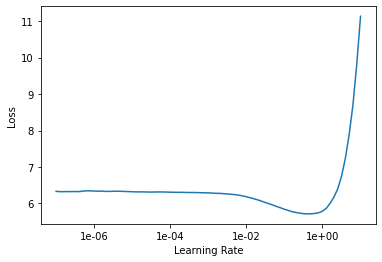

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.106220,3.818242,0.397233,01:06


In [ ]:
#To train the language model during fine-tuning
#unfreeze all the layers and then perform training for a low enough validation loss
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.583228,3.372523,0.434637,01:15
1,3.365567,3.184826,0.453083,01:15
2,3.193473,3.041442,0.467258,01:15
3,2.979309,2.946472,0.477845,01:16
4,2.790353,2.887398,0.484275,01:15
5,2.596194,2.896551,0.484519,01:15
6,2.328141,2.905043,0.489280,01:15
7,2.112540,2.968058,0.487666,01:15
8,1.902297,3.057803,0.487100,01:15
9,1.702128,3.155941,0.484290,01:16


In [ ]:
# Save the fine-tuned encoder
learn.save_encoder('./ft_enc')

In [ ]:
#train the classifier
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'ulmfit_train4.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


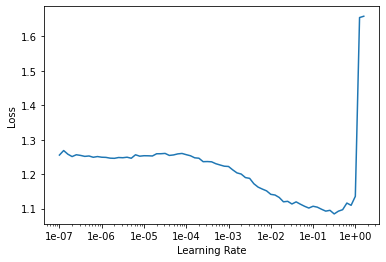

In [ ]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.620783,0.528213,0.732774,00:34


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.521826,0.480672,0.751591,00:39


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.501590,0.445926,0.771944,00:59


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.460764,0.434559,0.777924,01:22
1,0.423041,0.418161,0.788183,01:22
2,0.432329,0.408627,0.795315,01:25
3,0.425598,0.406301,0.797125,01:25


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,5667,28,1784
1,40,2593,29
2,1804,13,6270


In [ ]:
#evaluation
test_orig = pd.read_csv(path/testfile, encoding = "latin-1")
test_orig.head()

,Party,Tweet,Republican,Democrat,None
0,Republican,RELEASE: Small Business Committee Examines Rep...,1,0,0
1,Democrat,Congratulated the 2018 Hampton Roads Chamber o...,0,1,0
2,Republican,"Today, I pushed forward a bipartisan, bicamera...",1,0,0
3,Democrat,#NPWeek Did you know #Hawaii is home to 8 nati...,0,1,0
4,Republican,This past Saturday I spoke at MN Drone Day in ...,1,0,0


In [ ]:
test = pd.concat([test_orig['Party'], test_orig['Tweet']], axis=1)
test.tail()

,Party,Tweet
10122,None,RT @bradwhipple: Planters really out here tryi...
10123,Republican,During @NatResources meeting earlier today I r...
10124,Democrat,RT @RepDonBeyer: As House &amp; Senate hold he...
10125,Democrat,1460 days is an intolerably long time to wonde...
10126,Democrat,RT @uwghrc: Iraqi physician to speak on epidem...


In [ ]:
nan_values = test[test['Tweet'].isnull()]
nan_values

,Party,Tweet
4824,None,NaN


In [ ]:
len(test)

10127

In [ ]:
test = test.drop([4824])
len(test)

10126

In [ ]:
test['PredictedStance'] = test['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [ ]:
test.tail()

,Party,Tweet,PredictedStance
10122,None,RT @bradwhipple: Planters really out here tryi...,None
10123,Republican,During @NatResources meeting earlier today I r...,Republican
10124,Democrat,RT @RepDonBeyer: As House &amp; Senate hold he...,Democrat
10125,Democrat,1460 days is an intolerably long time to wonde...,Democrat
10126,Democrat,RT @uwghrc: Iraqi physician to speak on epidem...,Republican


In [ ]:
test.to_csv(path/'ulmfit_testresult.csv', index=False)

In [ ]:
test["Party"][1] == test["PredictedStance"][1]

True

In [ ]:
len(test)

10126

In [ ]:
results = pd.read_csv(path/'ulmfit_testresult.csv', encoding = "latin-1")

In [ ]:
results["Party"][4824]

'Republican'

In [ ]:
count = 0
for i in range(len(results)):
  if results["Party"][i] == results["PredictedStance"][i]:
    count += 1

In [ ]:
count

8090

In [ ]:
#Accuracy
count / len(test)

0.7989334386727237

## With preprocessing before training (url, @, #, etc)

In [ ]:
#https://xiangyutang2.github.io/tweet-classification/
#or normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL

## Augmented Vocabulary

In [7]:
train = pd.read_csv(path/'ulmfit_train4.csv', encoding = "latin-1")
train.head()

,Party,Tweet
0,Democrat,The Student Non-Discrimination Act will put an...
1,Republican,Ready for totality! Taking in #SolarEclipse201...
2,Democrat,Despite Republicans allowing them to go w/o fu...
3,Republican,We have an opportunity to finally gain operati...
4,Democrat,Honored to be included in @NYGovCuomo's #Women...


In [20]:
train["Tweet"][0]

'The Student Non-Discrimination Act will put an end to discrimination in schools based on sexual orientation or gend https://t.co/Vrz9l5fFku'

In [17]:
df_new = train['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

In [19]:
df_new[0]

'The Student Non-Discrimination Act will put an end to discrimination in schools based on sexual orientation or gend '

In [11]:
# only sampled a subset of 200,000 from the original Sentiment140 dataset for the language model fine-tuning
kaggle = pd.read_csv(path/"training.1600000.processed.noemoticon.csv",header=None,encoding = "latin-1")
kaggle.columns = ['col1', 'col2',"col3","Party","col5","Tweet"]
kaggle = kaggle[['Party','Tweet']]
# Clean Data and Remove URL's from the tweets
kaggle['Tweet'] = kaggle['Tweet'].apply(clean_ascii)
kaggle['Tweet'] = kaggle['Tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
kaggle_sub = kaggle.sample(n=200000,random_state=77)
kaggle_sub = kaggle_sub.append(train, ignore_index=True)

In [12]:
kaggle['Tweet'][:5]

0    @switchfoot  - A that's a bummer.  You shoulda...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: Tweet, dtype: object

In [21]:
# Write train to csv
kaggle_sub.to_csv(path/'kaggle_train_sub_v2.csv', index=False, header=False)
twitter_lm = TextLMDataBunch.from_csv(path, 'kaggle_train_sub_v2.csv', min_freq=1)
twitter_lm.save()
twitter_lm.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


NameError: ignored

In [2]:
twitter_lm.save()

NameError: ignored

In [8]:
twitter_lm = TextLMDataBunch.from_csv(path, 'kaggle_train_sub_v2.csv', min_freq=1)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [9]:
#Save the Vocab to a Pickle file for later use
pickle.dump(twitter_lm.train_ds.vocab, open(f'vocab.pkl','wb'))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


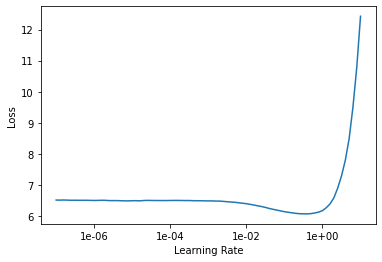

In [26]:
learn_twitter = language_model_learner(twitter_lm, arch=AWD_LSTM, drop_mult=0.1)
learn_twitter.lr_find(start_lr=1e-8, end_lr=1e2)
learn_twitter.recorder.plot()

In [27]:
learn_twitter = language_model_learner(twitter_lm, arch=AWD_LSTM,drop_mult=0.5)
learn_twitter.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.579918,4.308512,0.282635,02:39


In [29]:
learn_twitter.unfreeze()
learn_twitter.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8, 0.7))
# Save the fine-tuned encoder (Uncomment the line given below)
learn_twitter.save_encoder('ft_enc_kaggle_v1')

epoch,train_loss,valid_loss,accuracy,time
0,4.176123,3.988732,0.316631,03:00
1,3.994436,3.812267,0.334709,03:00
2,3.835246,3.708820,0.343829,03:00
3,3.712181,3.656013,0.350099,03:00
4,3.604348,3.628395,0.353360,03:00
5,3.479761,3.612784,0.355627,03:00
6,3.385575,3.615490,0.356429,03:00
7,3.306239,3.620751,0.356900,03:01
8,3.212654,3.628990,0.356930,03:01
9,3.200495,3.633675,0.356631,03:01


In [10]:
vocab_load = pickle.load(open('vocab.pkl', 'rb'))

In [11]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'ulmfit_train4.csv', vocab=vocab_load, min_freq=7, bs=64)
data_clas.save()
# learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
# learn.load_encoder('ft_enc_kaggle_v1')
# learn.freeze()

# #Find Optimum Learning Rate
# learn.lr_find(start_lr=1e-6, end_lr=1e2)
# learn.recorder.plot()

# #Train the Classifier by Gradually Unfreezing the Layers
# learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))
# #Unfreeze Layer
# learn.freeze_to(-2)
# learn.fit_one_cycle(3, slice(1e-4,1e-2), moms=(0.8,0.7))
# #Unfreeze Layer
# learn.freeze_to(-3)
# learn.fit_one_cycle(3, slice(1e-5,5e-3), moms=(0.8,0.7))
# #Unfreeze All Layers
# learn.unfreeze()
# learn.fit_one_cycle(3, slice(1e-5,1e-3), moms=(0.8,0.7))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TypeError: ignored

In [12]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc_kaggle_v1')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


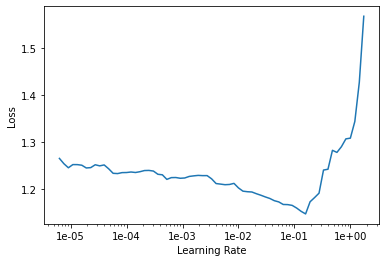

In [13]:
#Find Optimum Learning Rate
learn.lr_find(start_lr=1e-6, end_lr=1e2)
learn.recorder.plot()

In [14]:
#Train the Classifier by Gradually Unfreezing the Layers
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))
#Unfreeze Layer
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-4,1e-2), moms=(0.8,0.7))
#Unfreeze Layer
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(1e-5,5e-3), moms=(0.8,0.7))
#Unfreeze All Layers
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.828259,0.759174,0.600066,00:23


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch,train_loss,valid_loss,accuracy,time
0,0.715606,0.682480,0.639456,00:26
1,0.608142,0.557554,0.701503,00:27
2,0.559406,0.530855,0.718071,00:27


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,time
0,0.547213,0.520361,0.724600,00:38
1,0.528699,0.498172,0.742649,00:37
2,0.466830,0.486068,0.749616,00:39


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,time
0,0.486824,0.481216,0.753621,00:52
1,0.449857,0.469766,0.760753,00:56
2,0.436070,0.474174,0.759875,00:54


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [15]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,5416,58,1988
1,123,2582,86
2,2089,33,5853


In [16]:
#evaluation
test_orig = pd.read_csv(path/testfile, encoding = "latin-1")
test = pd.concat([test_orig['Party'], test_orig['Tweet']], axis=1)

In [17]:
nan_values = test[test['Tweet'].isnull()]
nan_values

,Party,Tweet
4824,None,NaN


In [18]:
len(test)

10127

In [19]:
test = test.drop([4824])
len(test)

10126

In [20]:
len(test)

10126

In [21]:
test['PredictedStance'] = test['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
test.tail()

,Party,Tweet,PredictedStance
10122,None,RT @bradwhipple: Planters really out here tryi...,None
10123,Republican,During @NatResources meeting earlier today I r...,Republican
10124,Democrat,RT @RepDonBeyer: As House &amp; Senate hold he...,Democrat
10125,Democrat,1460 days is an intolerably long time to wonde...,Democrat
10126,Democrat,RT @uwghrc: Iraqi physician to speak on epidem...,Republican


In [22]:
test.to_csv(path/'ulmfit_augmentedVocab_testresult.csv', index=False)

In [23]:
results = pd.read_csv(path/'ulmfit_augmentedVocab_testresult.csv', encoding = "latin-1")

In [24]:
count = 0
for i in range(len(results)):
  if results["Party"][i] == results["PredictedStance"][i]:
    count += 1

In [25]:
#Accuracy
count / len(test)

0.7656527750345645

In [ ]:
#preprocess for test dataset

In [26]:
test[:10]

,Party,Tweet,PredictedStance
0,Republican,RELEASE: Small Business Committee Examines Rep...,Republican
1,Democrat,Congratulated the 2018 Hampton Roads Chamber o...,Republican
2,Republican,"Today, I pushed forward a bipartisan, bicamera...",Democrat
3,Democrat,#NPWeek Did you know #Hawaii is home to 8 nati...,Democrat
4,Republican,This past Saturday I spoke at MN Drone Day in ...,Republican
5,Republican,It would be great to see a term limits bill pa...,Democrat
6,Democrat,I'm here on behalf of the newly formed Tech Ac...,Democrat
7,Republican,"Happy birthday, President Reagan! https://t.co...",Republican
8,Democrat,... and instead nominate someone who has had e...,Democrat
9,Republican,"I'm glad to have Butler, #PA's own Roger Newpo...",Republican


In [29]:
#remove URL
test['Tweet'] = test['Tweet'].str.replace(r'http(\S)+', r'')
test['Tweet'] = test['Tweet'].str.replace(r'http ...', r'')
test['Tweet'] = test['Tweet'].str.replace(r'http', r'')

In [30]:
# remove RT, @
test['Tweet'] = test['Tweet'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+',r'')
test['Tweet'] = test['Tweet'].str.replace(r'@[\S]+',r'')

In [33]:
#remove &, < and >
test['Tweet'] = test['Tweet'].str.replace(r'&amp;?',r'and')
test['Tweet'] = test['Tweet'].str.replace(r'&lt;',r'<')
test['Tweet'] = test['Tweet'].str.replace(r'&gt;',r'>')

In [34]:
# remove extra space
test['Tweet'] = test['Tweet'].str.replace(r'[ ]{2, }',r' ')

In [35]:
# insert space between punctuation marks
test['Tweet'] = test['Tweet'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
test['Tweet'] = test['Tweet'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')

In [36]:
# lower case and strip white spaces at both ends
test['Tweet'] = test['Tweet'].str.lower()
test['Tweet'] = test['Tweet'].str.strip()

In [37]:
test[:10]

,Party,Tweet,PredictedStance
0,Republican,release : small business committee examines re...,Republican
1,Democrat,congratulated the 2018 hampton roads chamber o...,Republican
2,Republican,"today , i pushed forward a bipartisan , bicame...",Democrat
3,Democrat,# npweek did you know # hawaii is home to 8 na...,Democrat
4,Republican,this past saturday i spoke at mn drone day in ...,Republican
5,Republican,it would be great to see a term limits bill pa...,Democrat
6,Democrat,i ' m here on behalf of the newly formed tech ...,Democrat
7,Republican,"happy birthday , president reagan !",Republican
8,Democrat,... and instead nominate someone who has had e...,Democrat
9,Republican,"i ' m glad to have butler , # pa ' s own roger...",Republican


In [38]:
test['PredictedStance_Cleaned'] = test['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
test.tail()

,Party,Tweet,PredictedStance,PredictedStance_Cleaned
10122,None,planters really out here trying to compete wit...,None,None
10123,Republican,during meeting earlier today i received some ...,Republican,None
10124,Democrat,as house and senate hold hearings on equifax ...,Democrat,Democrat
10125,Democrat,1460 days is an intolerably long time to wonde...,Democrat,Democrat
10126,Democrat,iraqi physician to speak on epidemic of birth ...,Republican,Republican


In [39]:
test.to_csv(path/'ulmfit_augmentedVocab_cleaned_testresult.csv', index=False)

In [52]:
results2 = pd.read_csv(path/'ulmfit_augmentedVocab_cleaned_testresult.csv', encoding = "latin-1")

In [53]:
count = 0
for i in range(len(results2)):
  if results2["Party"][i] == results2["PredictedStance_Cleaned"][i]:
    count += 1

In [54]:
#Accuracy
count / len(test)

0.6147540983606558